DATA PREPROCESSING

In [1]:
import os
import pandas as pd
import ipaddress
from PIL import Image
import matplotlib.pyplot as plt
from configurations import binary_lable
from utils import has_digit, remove_digits, remove_suffix, classifi_by_rules, decimal_to_256, nearest_square
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from configurations import traffic_rules
import math
from imblearn.over_sampling import ADASYN
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [6]:
# Thư mục chứa các file dataset đã transfer
dataset_folder = "new_transfered_dataset"
# Thư mục chức các file csv đã gán nhãn
classified_folder = "classified_dataset"
files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

Preprocessing 1. Đọc Dataset, gán nhãn, merge CSV files

In [7]:
print("##### START READING DATASET ######")
dataframes = []
file_indx = 1
flow_counter = {}
for file in files:
    file_path = os.path.join(dataset_folder, file)
    df = pd.read_csv(file_path)

    # Format tên các cột
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    file_name = file.split(".")[0]

    # Bỏ cột flow_id, timestamp
    df = df.drop('flow_id', axis=1)
    df = df.drop('timestamp', axis=1)

    # Chuyển hóa các địa chỉ IP thành int
    for index, row in df.iterrows():
        int_src_ip = int(ipaddress.ip_address(df.iloc[index]["src_ip"]))
        int_dst_ip = int(ipaddress.ip_address(df.iloc[index]["dst_ip"]))
        df.at[index, 'src_ip'] = int_src_ip
        df.at[index, 'dst_ip'] = int_dst_ip

    # Gán nhãn các row
    processed_name = remove_suffix(file_name)
    label = classifi_by_rules(traffic_rules, processed_name)
    file_indx = file_indx + 1
    if(label is not None):
        label_value = label[1]
        df["label"] = label_value
        dataframes.append(df) 
# # Lưu file
merged_df = pd.concat(dataframes, ignore_index=True)
merged_file_path = os.path.join(classified_folder, "traffics_dataset.csv")
merged_df.to_csv(merged_file_path, index=False)

print("##### READ DATASET DONE ######")

##### START READING DATASET ######
##### READ DATASET DONE ######


Preprocess 2. Mã hóa cơ số 256, áp dụng MinMaxScaler

In [8]:
print("##### START ENCODING DATASET ######")

expanded_df = pd.DataFrame()
merged_traffics = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
num_of_rows = merged_traffics.shape[0]
for column_name, column_data in merged_traffics.items():
    count = 1
    for index, value in enumerate(column_data):
        result = decimal_to_256(value)
        max_length = len(result)

        # Tạo tên cột mới và gán giá trị 0 cho toàn bộ cột mới
        for i in range(max_length):
            new_column_name = f'{column_name}_{i + 1}'
            if new_column_name not in expanded_df:
                expanded_df[new_column_name] = 0
            expanded_df.at[index, new_column_name] = result[i]
        count += 1

expanded_df.to_csv(merged_file_path, index=False)

# Scaling dữ liệu
traffics = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
selected_columns = [col for col in traffics.columns if col.endswith(
    '_1') and not any(f"{col[:-2]}_{i}" in traffics.columns for i in range(2, 10))]
# Loại bỏ label
selected_columns = [item for item in selected_columns if item != "label_1"]
# Khởi tạo Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 255))
# Áp dụng Min-Max Scaler
traffics[selected_columns] = scaler.fit_transform(
    traffics[selected_columns])
traffics.to_csv(merged_file_path, index=False)

print("##### ENCODING DONE ######")

##### START ENCODING DATASET ######
##### ENCODING DONE ######


Preprocess 3. Áp dụng ADASYN resampling

##### START RESAMPLING WITH ADASYN ######


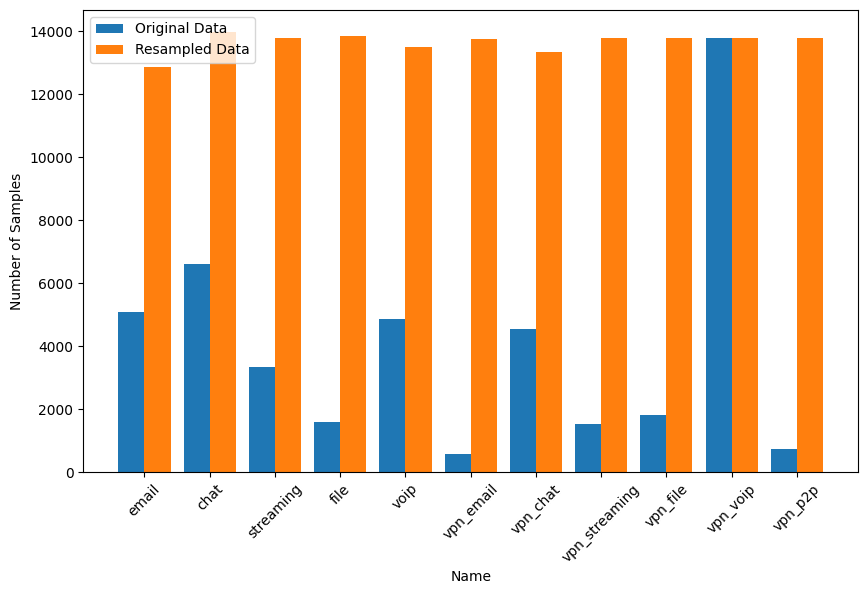

##### RESAMPLING WITH ADASYN DONE ######


In [9]:
print("##### START RESAMPLING WITH ADASYN ######")

data = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
original_class_distribution = data['label_1'].value_counts()

data.fillna(0, inplace=True)
X = data.drop('label_1', axis=1)  # Tập dữ liệu đầu vào
y = data['label_1']  # Nhãn
adasyn = ADASYN(sampling_strategy='not majority', random_state=42,
                n_neighbors=500)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data = pd.concat(
    [resampled_data, pd.DataFrame(y_resampled, columns=['label_1'])], axis=1)
resampled_class_distribution = resampled_data['label_1'].value_counts()
balanced_file_path = os.path.join(classified_folder, "traffics_dataset_balanced.csv")

combined_data = pd.concat([original_class_distribution, resampled_class_distribution], axis=1)
combined_data.columns = ['Original Data', 'Resampled Data']
combined_data = combined_data.sort_index()

class_labels = combined_data.index

label_to_name = {rule['label']: rule['name'] for rule in traffic_rules}
class_labels_mapped = [label_to_name[label] for label in class_labels]

plt.figure(figsize=(10, 6))
width = 0.4

plt.bar(range(len(class_labels_mapped)), combined_data['Original Data'], width=0.4, label='Original Data')
plt.bar([x + width for x in range(len(class_labels_mapped))], combined_data['Resampled Data'], width=0.4, label='Resampled Data')

plt.xlabel('Name')
plt.ylabel('Number of Samples')
plt.xticks([x + width/2 for x in range(len(class_labels_mapped))], class_labels_mapped, rotation=45)  # Set the x-ticks to be class names
plt.legend()
plt.show()

resampled_data.to_csv(balanced_file_path, index=False)
print("##### RESAMPLING WITH ADASYN DONE ######")

Preprocess 4. Fill các dữ liệu còn thiếu bằng 0

In [10]:
print("##### START ADDING ZEROS TO DATASET ######")

df = pd.read_csv(f'{classified_folder}/traffics_dataset_balanced.csv')
img_shape = nearest_square(df.shape[1]) + 1
num_new_columns = img_shape - df.shape[1]

for i in range(1, num_new_columns + 1):
    new_col_name = f'zeros_{i}'
    df.insert(df.shape[1] - 1, new_col_name, 0)
df.to_csv(merged_file_path, index=False)
print("Dataset's shape", df.shape)

print("##### ADD ZEROS TO DATASET DONE ######")

##### START ADDING ZEROS TO DATASET ######
Dataset's shape (150258, 226)
##### ADD ZEROS TO DATASET DONE ######


Preprocess 5. Chuyển từng dòng dữ liệu thành Image

In [11]:
print("##### START CREATTING IMAGES ######")

df = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
img_shape = nearest_square(df.shape[1]) + 1
data_img_shape = int(math.sqrt(img_shape-1))
for index, row in df.iterrows():
    data_row = df.iloc[index]
    label = data_row['label_1']
    data_row = data_row.drop('label_1')

    data_array = data_row.values.reshape(data_img_shape, data_img_shape)
    # Tạo hình ảnh từ mảng numpy
    image = Image.fromarray((data_array).astype('uint8'))

    output_folder = ""
    row_label = row["label_1"]
    for rule in traffic_rules:
        if rule["label"] == row_label:
            output_folder = rule["name"]
            
    output_folder_path = os.path.join(
        f'image_dataset/traffics_dataset/{output_folder}')
    # Tạo đường dẫn đầy đủ đến thư mục đích -> lưu
    output_path = os.path.join(
        f'image_dataset/traffics_dataset/{output_folder}', f'{index + 2}.png')
    
    # Kiểm tra nếu thư mục đích chưa tồn tại, thì tạo thư mục
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    image.save(output_path)

print("##### CONVERT TO IMAGE DONE. ######")

##### START CREATTING IMAGES ######
##### CONVERT TO IMAGE DONE. ######


MODEL TRAINING

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import torch.utils.data as data
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsummary import summary

Định nghĩa model

In [3]:
# Định nghĩa mô hình CNN
class CNNTrafficClassifier(nn.Module):
    def __init__(self, num_classes=11):
        super(CNNTrafficClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32) 
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32) 
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 3 * 3, 128) 
        self.relu5 = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)

        x = self.dropout(x)

        x = self.fc2(x)
        return x


model = CNNTrafficClassifier()

Chuẩn hóa dataset

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Resize((15, 15)),
    transforms.Grayscale(),    # Chuyển đổi thành ảnh xám
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [4]:
dataset_root = "image_dataset/traffics_dataset"  # Thư mục gốc chứa dataset
dataset = datasets.ImageFolder(
    root=dataset_root, transform=data_transform)

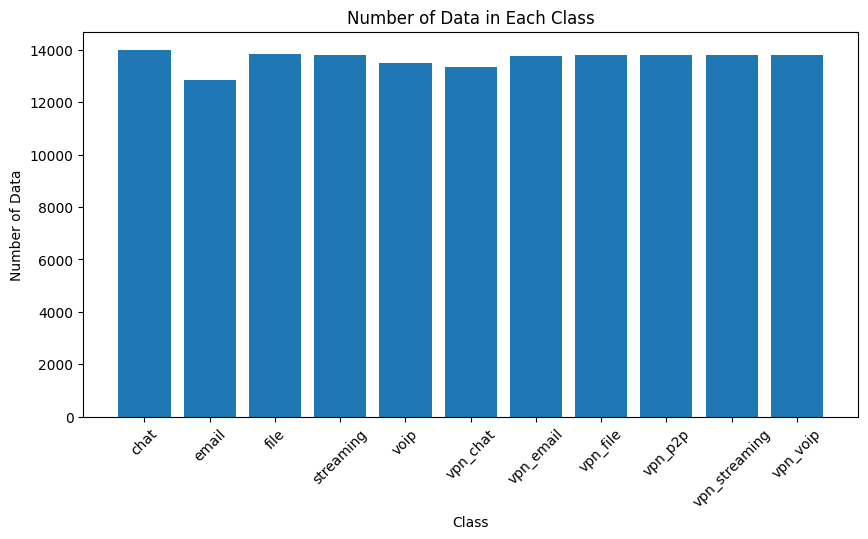

In [5]:
class_names_title = dataset.classes

class_sample_counts = {}
for label in class_names_title:
    # Đường dẫn tới thư mục của lớp
    class_dir = os.path.join(dataset_root, label)
    count = len([f for f in os.listdir(class_dir) if f.endswith('.png')])
    class_sample_counts[label] = count

plt.figure(figsize=(10, 5))
plt.bar(class_sample_counts.keys(), [
        count for count in class_sample_counts.values()])
plt.xlabel("Class")
plt.ylabel("Number of Data")
plt.title("Number of Data in Each Class")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Chia Train/Validate/Test tỉ lệ 70 - 15 - 15
batch_size = 256  # Kích thước batch
total_samples = len(dataset)

# Chia lượng data được sử dụng
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Lấy datata random theo tỉ lệ
selected_samples = random.sample(range(total_samples), samples_to_use)

# Tạo ra các subset trên mỗi sample
dataset = data.Subset(dataset, selected_samples)
total_samples = len(dataset)

train_size = int((0.7 * total_samples))
validate_size = int((0.15 * total_samples))
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)


Total 150258
Test Amount 22540
Train Amount 105180
Validation Amount 22538


In [4]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    current_gpu = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Have {gpu_count} GPU available.")
    print(f"GPU's name: {gpu_name}")
else:
    print("No GPU available.")
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Have 1 GPU available.
GPU's name: NVIDIA GeForce GTX 1050
11.7


In [5]:
model = CNNTrafficClassifier().to(device)
summary(model, (1, 15, 15))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 15, 15]             160
       BatchNorm2d-2           [-1, 16, 15, 15]              32
              ReLU-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 32, 15, 15]           4,640
       BatchNorm2d-5           [-1, 32, 15, 15]              64
              ReLU-6           [-1, 32, 15, 15]               0
         MaxPool2d-7             [-1, 32, 7, 7]               0
            Conv2d-8             [-1, 32, 7, 7]           9,248
       BatchNorm2d-9             [-1, 32, 7, 7]              64
             ReLU-10             [-1, 32, 7, 7]               0
        MaxPool2d-11             [-1, 32, 3, 3]               0
           Linear-12                  [-1, 128]          36,992
             ReLU-13                  [-1, 128]               0
          Dropout-14                  [

In [8]:
num_epochs = 200  # Số lượng epoch
learning_rate = 0.0001

In [9]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
best_accuracy = 0.0  # Giá trị accuracy tốt nhất
patience = 10  # Số epoch không giảm loss cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện
weight_decay = 0.001

Train model

In [12]:
if torch.cuda.is_available():
    # Chuyển mô hình và dữ liệu lên GPU
    model = model.to(device)

    # Tạo hàm mất mát và tối ưu hóa trên GPU
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
        train_loss = 0
        correct_predictions = 0
        total_samples = 0
        model.train()
        # Lặp qua từng batch trong dữ liệu
        for images, labels in train_loader:  # train_dataloader chứa dữ liệu huấn luyện
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Feed-forward
            loss = criterion(outputs, labels)  # Tính hàm mất mát
            
            optimizer.zero_grad()  # Xóa gradient
            loss.backward()  # Lan truyền ngược để tính gradient
            optimizer.step()  # Cập nhật trọng số mô hình
            train_loss += loss.item() # Cost
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        train_accuracy = correct_predictions / total_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss/len(train_loader)) #Lost: Trung bình cộng các Cost

        # Đánh giá trên tập validate
        validate_loss = 0
        validate_correct_predictions = 0
        validate_total_samples = 0

        model.eval()  # Chuyển sang chế độ đánh giá

        for i, (images, labels) in enumerate(validate_loader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # Không tính đạo hàm trong quá trình đánh giá
                outputs = model(images)
                loss = criterion(outputs, labels)  # Tính hàm mất mát
                validate_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                validate_total_samples += labels.size(0)
                validate_correct_predictions += (predicted ==
                                                 labels).sum().item()

        validate_accuracy = validate_correct_predictions / validate_total_samples
        validate_accuracy_list.append(validate_accuracy)
        validate_loss_list.append(validate_loss/len(validate_loader))

        print(
            f"Training loss={train_loss_list[-1]}, Training Accuracy={train_accuracy * 100:.2f}%, "
            f"Validation loss={validate_loss_list[-1]}, Validation Accuracy={validate_accuracy * 100:.2f}%")

        if validate_loss_list[-1] >= best_loss:
            no_improvement_count += 1
        else:
            best_loss = validate_loss_list[-1]
            no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/200: Training loss=1.6146725317567514, Training Accuracy=45.79%, Validation loss=0.9982578874973769, Validation Accuracy=66.06%
Epoch 2/200: Training loss=0.9580144084573082, Training Accuracy=65.33%, Validation loss=0.7240705061494634, Validation Accuracy=73.63%
Epoch 3/200: Training loss=0.7537622402474248, Training Accuracy=72.07%, Validation loss=0.5951401738638289, Validation Accuracy=77.97%
Epoch 4/200: Training loss=0.6426592221225265, Training Accuracy=75.70%, Validation loss=0.5335002926628242, Validation Accuracy=79.07%
Epoch 5/200: Training loss=0.5728561717953415, Training Accuracy=78.16%, Validation loss=0.4814630797070064, Validation Accuracy=81.37%
Epoch 6/200: Training loss=0.5257101153950332, Training Accuracy=79.72%, Validation loss=0.44283932213033184, Validation Accuracy=82.60%
Epoch 7/200: Training loss=0.48997085728204454, Training Accuracy=80.92%, Validation loss=0.42066537798120734, Validation Accuracy=83.47%
Epoch 8/200: Training loss=0.4618881490543811

Lưu model checkpoint

In [13]:
model_save_path = "GUI/models/traffics_classification.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification.pth


Load model checkpoint

In [10]:
model_save_path = "GUI/models/traffics_classification.pth"
# Load lại model
model = CNNTrafficClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Dự đoán trên tập Test

In [11]:
model.eval()  # Chuyển mô hình sang chế độ đánh giá
correct_predictions = 0
total_samples = 0
all_predictions = []
all_labels = []

# Khởi tạo danh sách để lưu trữ xác suất dự đoán cho từng lớp
all_probs = []

with torch.no_grad():  # Tắt tính toán gradient trong quá trình đánh giá
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Feed-forward
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct_predictions / total_samples
all_probs = np.array(all_probs)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

label_to_class_name = {index: class_name for index,
                       class_name in enumerate(class_names_title)}
label_display = [label_to_class_name[label]
                 for label in range(len(class_names_title))]

for label, class_name in enumerate(label_display):
    print(f"Label {label}: {class_name}")

Test Accuracy: 92.05%
Label 0: chat
Label 1: email
Label 2: file
Label 3: streaming
Label 4: voip
Label 5: vpn_chat
Label 6: vpn_email
Label 7: vpn_file
Label 8: vpn_p2p
Label 9: vpn_streaming
Label 10: vpn_voip


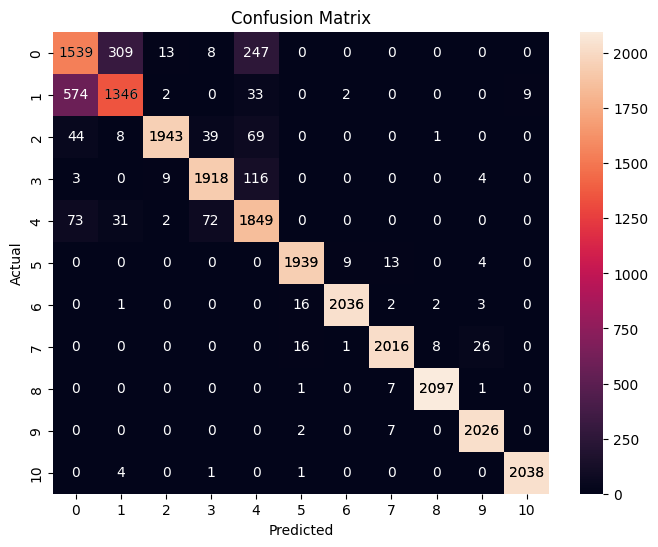

In [12]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

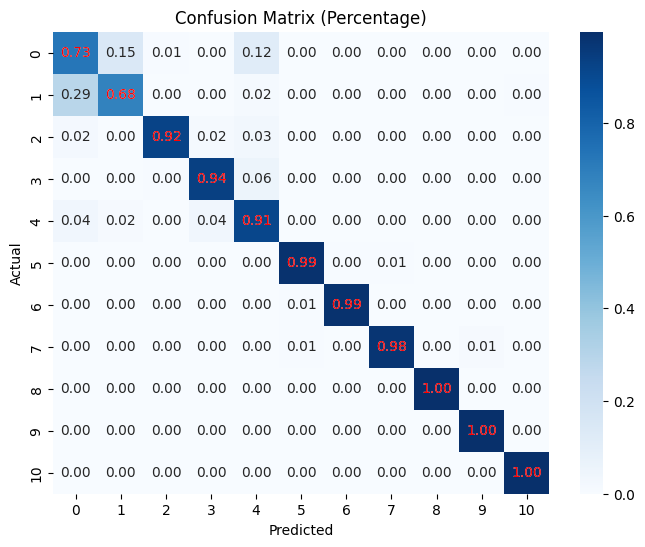

In [13]:
# Tính confusion matrix theo tỉ số
cm = confusion_matrix(all_labels, all_predictions)

# Chuyển ma trận nhầm lẫn sang dạng phần trăm
# Chia mỗi hàng cho tổng của hàng đó
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# In ra confusion matrix dưới dạng phần trăm
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5,
             f"{cm[i, i] / sum(cm[i, :]):.2f}", ha="center", va="center", color="red")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

Phân tích trên đồ thị

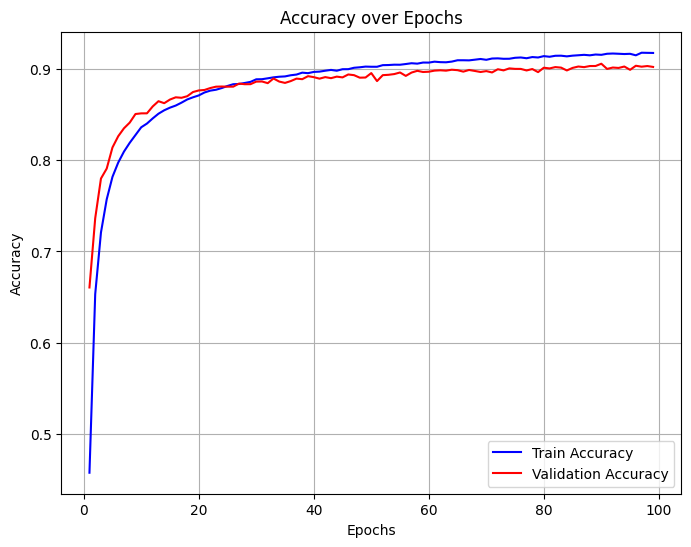

In [14]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

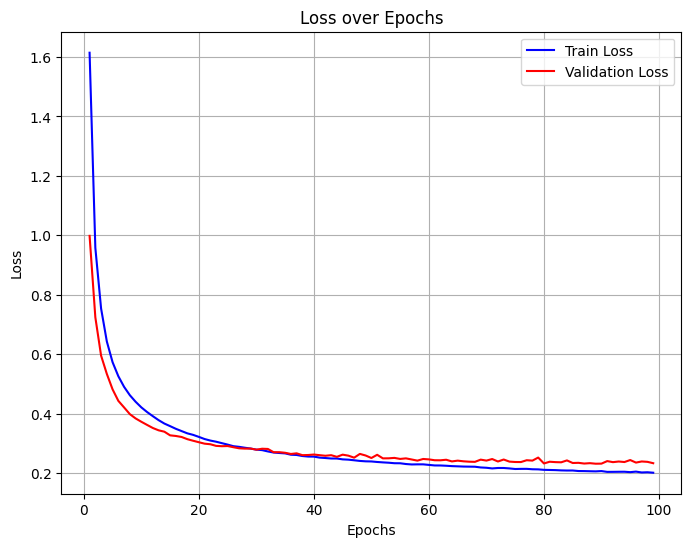

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Đánh giá model theo từng đại lượng

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd

In [17]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

accuracies = []
for label in range(len(class_names_title)):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    label_predictions = [all_predictions[i] for i in indices]
    label_true = [all_labels[i] for i in indices]
    accuracy = accuracy_score(label_true, label_predictions)
    accuracies.append(accuracy)

data = {'Class': label_display, 'Precision': precisions,
        'Recall': recalls, 'F1-Score': f1_scores, 'Accuracy': accuracies}
df = pd.DataFrame(data)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(df)
print("Model's precision", average_precision)
print("Model's recall", average_recall)
print("Model's f1-score",average_f1_score)
print(f"Model's Accuracy: {test_accuracy}%")

            Class  Precision    Recall  F1-Score  Accuracy
0            chat   0.689207  0.727316  0.707749  0.727316
1           email   0.792231  0.684639  0.734516  0.684639
2            file   0.986795  0.923479  0.954088  0.923479
3       streaming   0.941119  0.935610  0.938356  0.935610
4            voip   0.799049  0.912185  0.851877  0.912185
5        vpn_chat   0.981772  0.986768  0.984264  0.986768
6       vpn_email   0.994141  0.988350  0.991237  0.988350
7        vpn_file   0.985819  0.975327  0.980545  0.975327
8         vpn_p2p   0.994782  0.995726  0.995254  0.995726
9   vpn_streaming   0.981589  0.995577  0.988534  0.995577
10       vpn_voip   0.995603  0.997065  0.996333  0.997065
Model's precision 0.9220097732569424
Model's recall 0.9201856257419265
Model's f1-score 0.9202502310585943
Model's Accuracy: 0.920452528837622%


AUC for chat: 0.98
AUC for email: 0.99
AUC for file: 1.00
AUC for streaming: 1.00
AUC for voip: 0.99
AUC for vpn_chat: 1.00
AUC for vpn_email: 1.00
AUC for vpn_file: 1.00
AUC for vpn_p2p: 1.00
AUC for vpn_streaming: 1.00
AUC for vpn_voip: 1.00


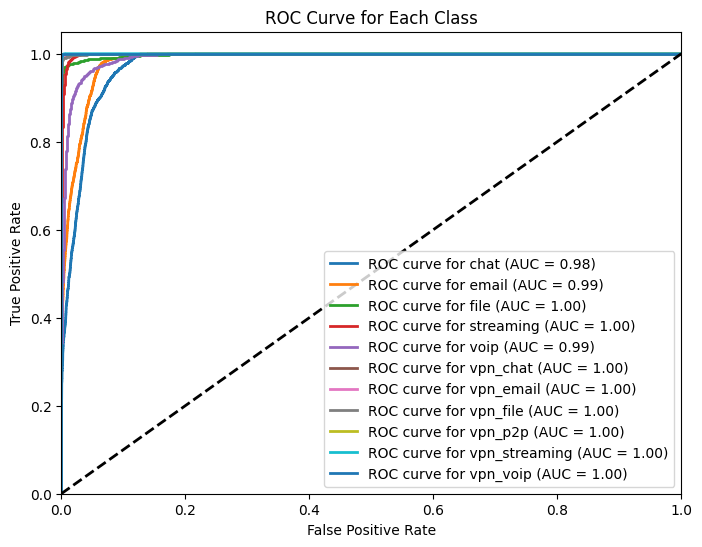

In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names_title)):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'AUC for {class_names_title[i]}: {roc_auc[i]:.2f}')

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names_title):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Transfer learning

In [27]:
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.data import random_split
import random
import torch.utils.data as data
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.Grayscale(num_output_channels=3), # Chuyển đổi thành ảnh xám, 3 kênh màu xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [25]:
dataset_root = "image_dataset/traffics_dataset/"  # Thư mục gốc chứa dataset
train_dataset = ImageFolder(
    root=dataset_root, transform=data_transform)
class_names_title = train_dataset.classes
label_to_class_name = {index: class_name for index,
                       class_name in enumerate(class_names_title)}
label_display = [label_to_class_name[label]
                 for label in range(len(class_names_title))]
print(class_names_title)

['chat', 'email', 'file', 'streaming', 'voip', 'vpn_chat', 'vpn_email', 'vpn_file', 'vpn_p2p', 'vpn_streaming', 'vpn_voip']


In [5]:
batch_size = 512  # Kích thước batch
total_samples = len(train_dataset)

# Chia lượng data được sử dụng
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Lấy datata random theo tỉ lệ
selected_samples = random.sample(range(total_samples), samples_to_use)

# Tạo ra các subset trên mỗi sample
train_dataset = data.Subset(train_dataset, selected_samples)
total_samples = len(train_dataset)

train_size = int(0.7 * total_samples)
validate_size = int(0.15 * total_samples)
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Total 150258
Test Amount 22540
Train Amount 105180
Validation Amount 22538


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


ResNet50

In [28]:
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False
num_classes = 11
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), 
    nn.LogSoftmax(dim=1)
)

In [29]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.001

In [30]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        resnet50.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [31]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [32]:
resnet50.to(device)
for epoch in range(num_epochs):
    resnet50.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    resnet50.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 1.9412, Train Accuracy: 34.35%, Validation Loss: 1.6199, Validation Accuracy: 47.17%
Epoch 2/200, Train Loss: 1.6088, Train Accuracy: 46.10%, Validation Loss: 1.4657, Validation Accuracy: 51.61%
Epoch 3/200, Train Loss: 1.4914, Train Accuracy: 49.81%, Validation Loss: 1.3721, Validation Accuracy: 54.10%
Epoch 4/200, Train Loss: 1.4163, Train Accuracy: 51.87%, Validation Loss: 1.3217, Validation Accuracy: 55.28%
Epoch 5/200, Train Loss: 1.3664, Train Accuracy: 53.49%, Validation Loss: 1.2802, Validation Accuracy: 56.73%
Epoch 6/200, Train Loss: 1.3263, Train Accuracy: 54.70%, Validation Loss: 1.2351, Validation Accuracy: 57.54%
Epoch 7/200, Train Loss: 1.2899, Train Accuracy: 55.94%, Validation Loss: 1.2025, Validation Accuracy: 58.42%
Epoch 8/200, Train Loss: 1.2612, Train Accuracy: 56.53%, Validation Loss: 1.1704, Validation Accuracy: 59.33%
Epoch 9/200, Train Loss: 1.2347, Train Accuracy: 57.57%, Validation Loss: 1.1589, Validation Accuracy: 59.89%
Epoch 10/2

In [33]:
model_save_path = "GUI/models/traffics_classification_resnet50.pth"
torch.save({
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_resnet50.pth


In [8]:
model_save_path = "GUI/models/traffics_classification_resnet50.pth"
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False
num_classes = 11
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), 
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
resnet50.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [9]:
resnet50 = resnet50.to(device)
resnet50.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = resnet50(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.771606033717835


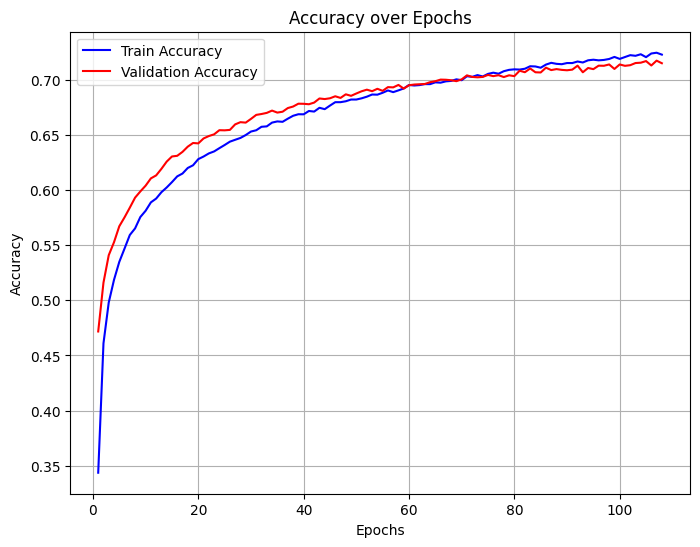

In [18]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

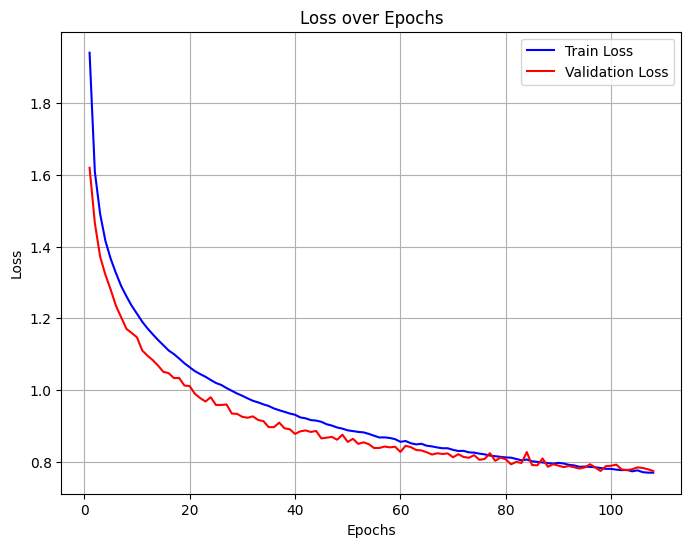

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

ResNet50's Confusion Matrix:


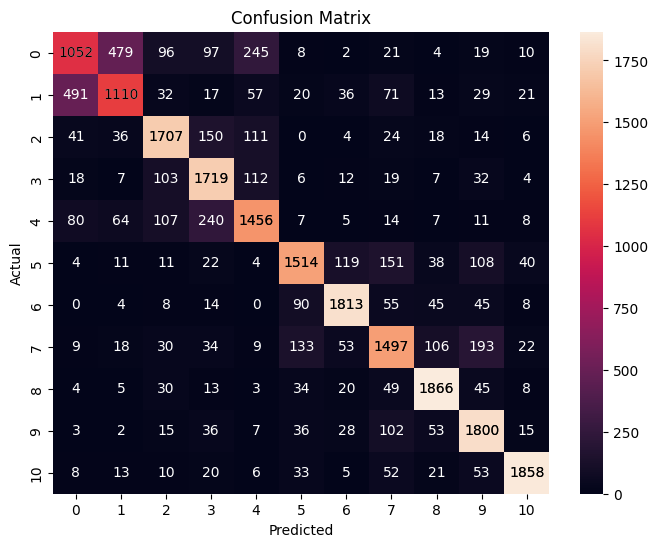

In [17]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("ResNet50's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

resnet50_precision = np.mean(precisions)
resnet50_recall = np.mean(recalls)
resent50_f1_score = np.mean(f1_scores)
resnet50_acc = predict_accuracy

print("ResNet50's precision", resnet50_precision)
print("ResNet50's recall", resnet50_recall)
print("ResNet50's f1-score",resent50_f1_score)
print(f"ResNet50's Accuracy: {resnet50_acc}")

ResNet50's precision 0.7678442371704441
ResNet50's recall 0.7694712989205886
ResNet50's f1-score 0.767376578131827
ResNet50's Accuracy: 0.771606033717835


AlexNet

In [69]:
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 11
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [70]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.001

In [71]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        alexnet.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [72]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [73]:
alexnet.to(device)
for epoch in range(num_epochs):
    alexnet.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    alexnet.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')


    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 1.6278, Train Accuracy: 43.47%, Validation Loss: 1.2054, Validation Accuracy: 57.30%
Epoch 2/200, Train Loss: 1.2956, Train Accuracy: 54.81%, Validation Loss: 1.0727, Validation Accuracy: 61.18%
Epoch 3/200, Train Loss: 1.1884, Train Accuracy: 57.96%, Validation Loss: 0.9876, Validation Accuracy: 65.35%
Epoch 4/200, Train Loss: 1.1229, Train Accuracy: 60.30%, Validation Loss: 0.9371, Validation Accuracy: 66.14%
Epoch 5/200, Train Loss: 1.0763, Train Accuracy: 61.83%, Validation Loss: 0.9327, Validation Accuracy: 67.13%
Epoch 6/200, Train Loss: 1.0393, Train Accuracy: 63.06%, Validation Loss: 0.8784, Validation Accuracy: 68.23%
Epoch 7/200, Train Loss: 1.0084, Train Accuracy: 63.95%, Validation Loss: 0.8500, Validation Accuracy: 68.75%
Epoch 8/200, Train Loss: 0.9853, Train Accuracy: 64.69%, Validation Loss: 0.8446, Validation Accuracy: 68.85%
Epoch 9/200, Train Loss: 0.9625, Train Accuracy: 65.67%, Validation Loss: 0.8069, Validation Accuracy: 70.53%
Epoch 10/2

In [74]:
model_save_path = "GUI/models/traffics_classification_alexnet.pth"
torch.save({
    'model_state_dict': alexnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_alexnet.pth


In [31]:
model_save_path = "GUI/models/traffics_classification_alexnet.pth"
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 11
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
alexnet.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [33]:
alexnet = alexnet.to(device)
alexnet.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = alexnet(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.8669920141969831


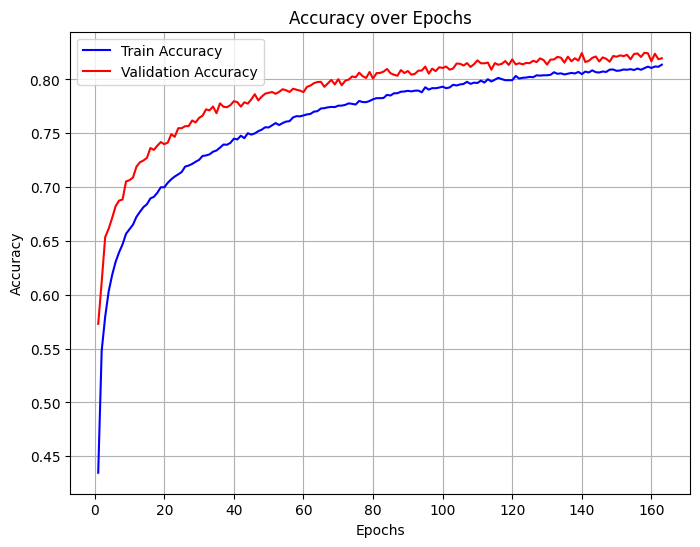

In [34]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

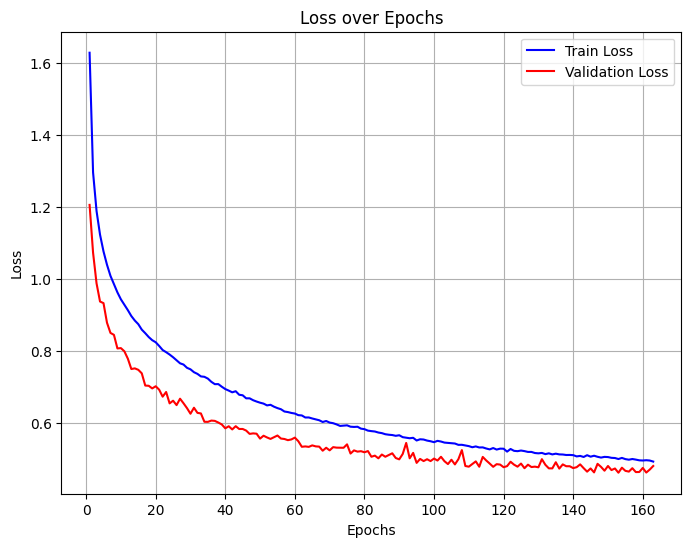

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

AlexNet's Confusion Matrix:


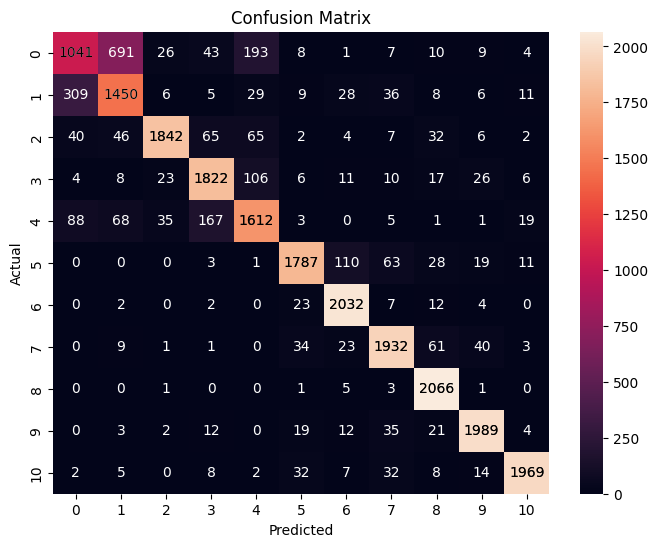

In [36]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("AlexNet's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

alexnet_precision = np.mean(precisions)
alexnet_recall = np.mean(recalls)
alexnet_f1_score = np.mean(f1_scores)
alexnet_acc = predict_accuracy

print("AlexNet's precision", alexnet_precision)
print("AlexNet's recall", alexnet_recall)
print("AlexNet's f1-score",alexnet_f1_score)
print(f"AlexNet's Accuracy: {alexnet_acc}")

AlexNet's precision 0.8648707732767758
AlexNet's recall 0.8652065805114131
AlexNet's f1-score 0.8626267142838769
AlexNet's Accuracy: 0.8669920141969831


VGG-16

In [15]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 11
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [16]:
learning_rate = 0.0001
num_epochs = 60
weight_decay = 0.0001

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        vgg16.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [18]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [19]:
vgg16.to(device)
for epoch in range(num_epochs):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/60, Train Loss: 1.3585, Train Accuracy: 51.27%, Validation Loss: 0.9097, Validation Accuracy: 66.08%
Epoch 2/60, Train Loss: 0.9299, Train Accuracy: 66.02%, Validation Loss: 0.7455, Validation Accuracy: 71.35%
Epoch 3/60, Train Loss: 0.7968, Train Accuracy: 70.29%, Validation Loss: 0.6826, Validation Accuracy: 73.90%
Epoch 4/60, Train Loss: 0.7247, Train Accuracy: 72.85%, Validation Loss: 0.6303, Validation Accuracy: 76.11%
Epoch 5/60, Train Loss: 0.6716, Train Accuracy: 74.70%, Validation Loss: 0.5798, Validation Accuracy: 77.45%
Epoch 6/60, Train Loss: 0.6276, Train Accuracy: 76.09%, Validation Loss: 0.5702, Validation Accuracy: 78.11%
Epoch 7/60, Train Loss: 0.5971, Train Accuracy: 77.30%, Validation Loss: 0.5438, Validation Accuracy: 78.77%
Epoch 8/60, Train Loss: 0.5709, Train Accuracy: 77.97%, Validation Loss: 0.5210, Validation Accuracy: 79.54%
Epoch 9/60, Train Loss: 0.5459, Train Accuracy: 78.88%, Validation Loss: 0.5044, Validation Accuracy: 80.77%
Epoch 10/60, Train 

In [20]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_vgg16.pth


In [40]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 11
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [41]:
vgg16 = vgg16.to(device)
vgg16.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = vgg16(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.8944099378881988


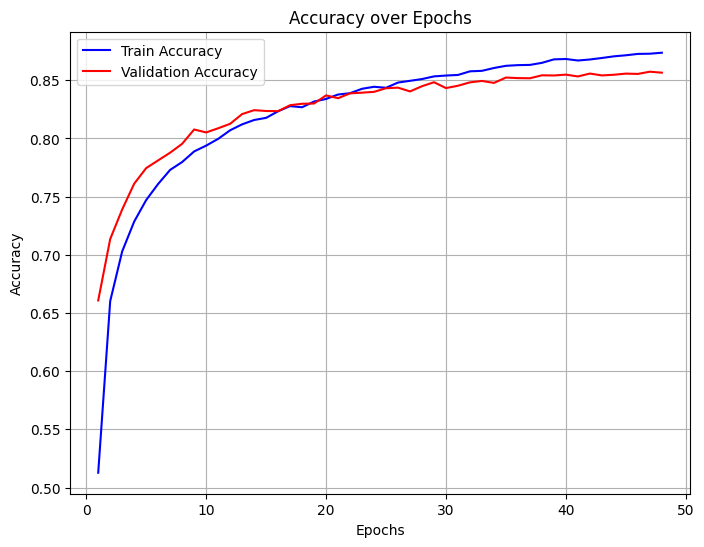

In [42]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

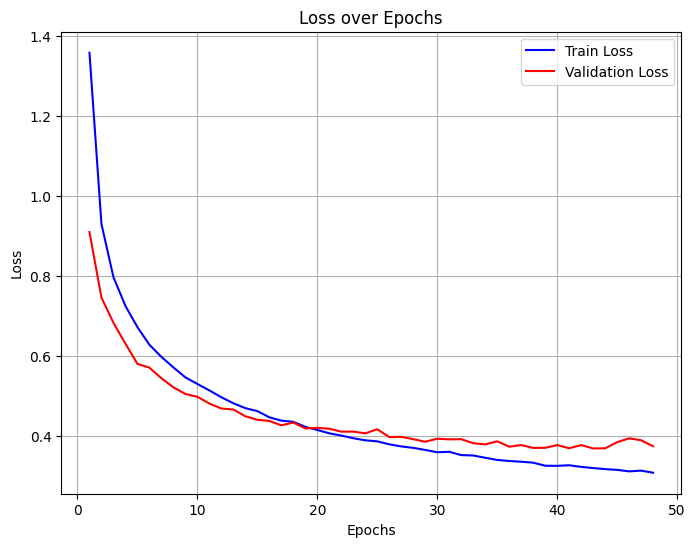

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

VGG-16's Confusion Matrix:


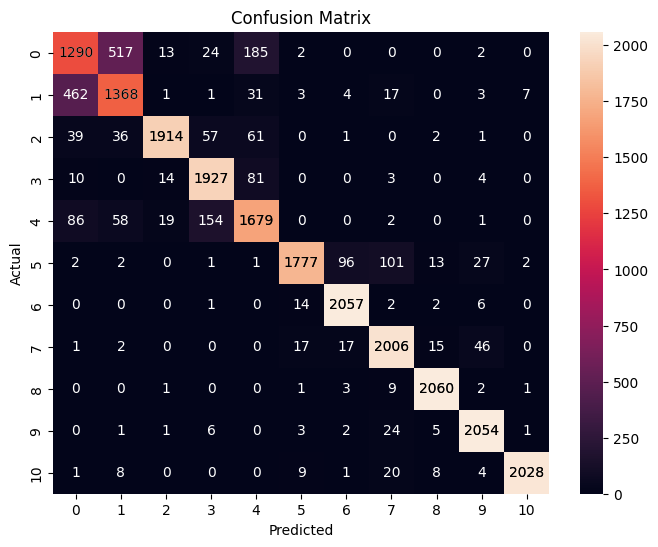

In [44]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("VGG-16's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

vgg16_precision = np.mean(precisions)
vgg16_recall = np.mean(recalls)
vgg16_f1_score = np.mean(f1_scores)
vgg16_acc = predict_accuracy

print("VGG-16's precision", vgg16_precision)
print("VGG-16's recall", vgg16_recall)
print("VGG-16's f1-score",vgg16_f1_score)
print(f"VGG-16's Accuracy: {vgg16_acc}")

VGG-16's precision 0.8926186826031803
VGG-16's recall 0.8922150072263425
VGG-16's f1-score 0.891776930159455
VGG-16's Accuracy: 0.8944099378881988


DenseNet-121

In [30]:
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 11
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [31]:
learning_rate = 0.001
num_epochs = 200
weight_decay = 0.0001

In [32]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        densenet121.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [33]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [34]:
densenet121.to(device)
for epoch in range(num_epochs):
    densenet121.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = densenet121(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    densenet121.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = densenet121(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 1.5083, Train Accuracy: 47.89%, Validation Loss: 1.1803, Validation Accuracy: 58.34%
Epoch 2/200, Train Loss: 1.2175, Train Accuracy: 57.10%, Validation Loss: 1.0823, Validation Accuracy: 62.03%
Epoch 3/200, Train Loss: 1.1414, Train Accuracy: 59.56%, Validation Loss: 1.0136, Validation Accuracy: 63.41%
Epoch 4/200, Train Loss: 1.0916, Train Accuracy: 60.96%, Validation Loss: 0.9752, Validation Accuracy: 64.79%
Epoch 5/200, Train Loss: 1.0571, Train Accuracy: 62.03%, Validation Loss: 0.9636, Validation Accuracy: 65.51%
Epoch 6/200, Train Loss: 1.0325, Train Accuracy: 62.83%, Validation Loss: 0.9446, Validation Accuracy: 66.23%
Epoch 7/200, Train Loss: 1.0131, Train Accuracy: 63.31%, Validation Loss: 0.9360, Validation Accuracy: 66.71%
Epoch 8/200, Train Loss: 0.9951, Train Accuracy: 64.03%, Validation Loss: 0.9116, Validation Accuracy: 67.31%
Epoch 9/200, Train Loss: 0.9825, Train Accuracy: 64.21%, Validation Loss: 0.8957, Validation Accuracy: 67.29%
Epoch 10/2

In [35]:
model_save_path = "GUI/models/traffics_classification_densenet121.pth"
torch.save({
    'model_state_dict': densenet121.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_densenet121.pth


In [49]:
model_save_path = "GUI/models/traffics_classification_densenet121.pth"

densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 11
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
densenet121.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [50]:
densenet121 = densenet121.to(device)
densenet121.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = densenet121(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.7573203194321206


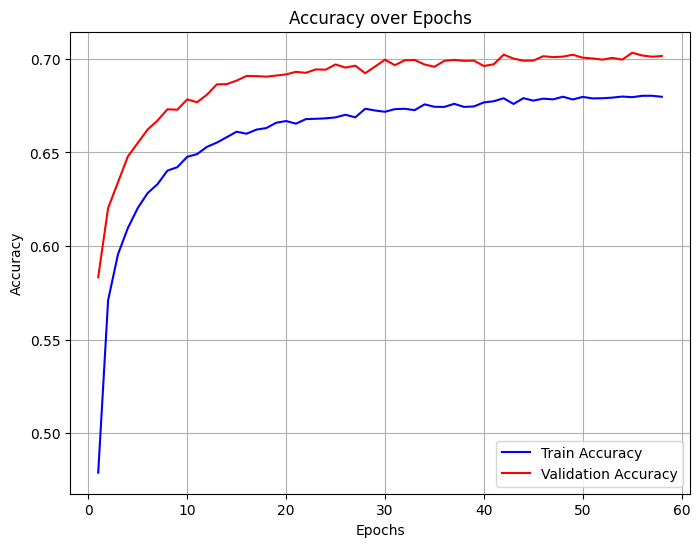

In [51]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

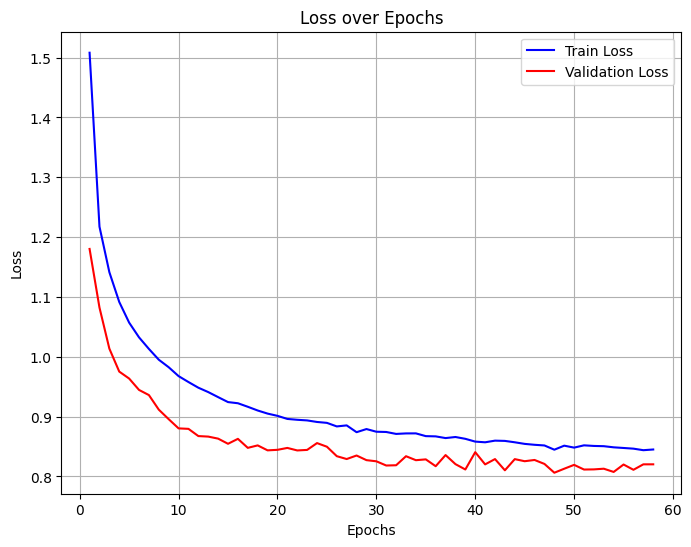

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

DenseNet121's Confusion Matrix:


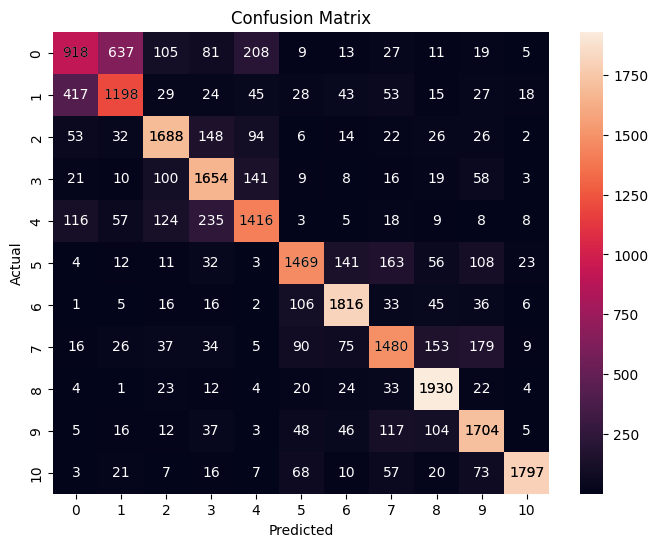

In [53]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("DenseNet121's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

densenet121_precision = np.mean(precisions)
densenet121_recall = np.mean(recalls)
densenet121_f1_score = np.mean(f1_scores)
densenet121_acc = predict_accuracy

print("DenseNet121's precision", densenet121_precision)
print("DenseNet121's recall", densenet121_recall)
print("DenseNet121's f1-score",densenet121_f1_score)
print(f"DenseNet121's Accuracy: {densenet121_acc}")

DenseNet121's precision 0.7540972516723525
DenseNet121's recall 0.755506442607719
DenseNet121's f1-score 0.7527627445700077
DenseNet121's Accuracy: 0.7573203194321206
